# Word Segmentation Modelling (version : alam.2.0)

This is the modelling documentation of Word Segmentation

First Structured :


Input :

    Slides Data
    WORD2VEC 50
    

output :

    Multi Conv LSTM


## Plan

    [*] Get Data
    [*] Transform the data
    [ ] Prepare the model
    [ ] Train it

In [1]:
%matplotlib inline
import sys
sys.path.append('../scr/')
import pandas as pd
import torch
import numpy as np
import os
import pickle
import WordSegmenTools as wst
from torch.autograd import Variable
import random
from sklearn.preprocessing import OneHotEncoder
from gensim.models import Word2Vec
import time

In [2]:
PATH_DATA_RAW='../../data/raw/'
PATH_DATA_CLN='../../data/clean/'
PATH_MODEL='../../data/model/'

In [3]:
os.listdir(PATH_DATA_CLN)

['.ipynb_checkpoints', 'data_clean_100k.res', 'data_train2_for_slides.res']

In [4]:
os.listdir(PATH_MODEL)

['char_embed_25.res', 'char_embed_50.res', 'char_embed_75.res']

## Get Data

In [5]:
SEQ_LENGTH=6

In [6]:
# data_cln=pd.read_csv(PATH_DATA_CLN+'data_clean_100k.res')
data_cln=pickle.load(open(PATH_DATA_CLN+'data_train2_for_slides.res','rb'))
w2v = Word2Vec.load(PATH_MODEL+"char_embed_50.res")

/Users/alamhanz/anaconda/envs/word_s/lib/python3.7/site-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [7]:
data_cln['slides_trim']=data_cln.slides.apply(lambda x: x.strip())

In [8]:
data_cln.head()

,slides,ori_len,slides_no_space,space_cnt,slides_no_space_len,slides_trim
20,katany,6,katany,0,6,katany
21,atanya,6,atanya,0,6,atanya
28,pembel,6,pembel,0,6,pembel
29,embeli,6,embeli,0,6,embeli
30,mbelia,6,mbelia,0,6,mbelia


In [9]:
## second space position should reduce by 1 in prediction
data_cln['space_position']=data_cln.slides_trim.apply(lambda x : ','.join((np.where(np.array(list(x)) == ' ')[0]).astype(str)))

In [10]:
data_cln['id']=[i for i in range(len(data_cln))]

In [11]:
data_cln.sample(10)

,slides,ori_len,slides_no_space,space_cnt,slides_no_space_len,slides_trim,space_position,id
2938491,ideal s,7,ideals,1,6,ideal s,5,782919
4142006,ihapus,7,ihapus,0,6,ihapus,,1662185
3771475,anya pi,7,anyapi,1,6,anya pi,4,1391002
3599978,solskj,7,solskj,0,6,solskj,,1266129
3178669,upus te,7,upuste,1,6,upus te,4,958387
5690725,au hadi,8,auhadi,1,6,au hadi,2,2222103
2456941,pendap,6,pendap,0,6,pendap,,454515
3598840,kan saa,7,kansaa,1,6,kan saa,3,1265300
2603627,us ters,7,usters,1,6,us ters,2,538251
3655339,i pemai,7,ipemai,1,6,i pemai,1,1306313


## Transform Data

In [12]:
def target_generator(x):
    basic=np.zeros(SEQ_LENGTH)
    if len(x)==0:
        return basic
    else:
        for x in x.split(','):
            basic[int(x)-1]=1
        return basic

In [13]:
target_generator('')

array([0., 0., 0., 0., 0., 0.])

In [14]:
data_used=pd.concat([data_cln[data_cln.space_cnt==0].sample(30000,random_state=125),
                     data_cln[data_cln.space_cnt==1].sample(40000,random_state=125),
                     data_cln[data_cln.space_cnt==2].sample(35000,random_state=125)])

In [15]:
len(data_used)*0.8

84000.0

In [16]:
data_used_train=data_used.sample(84000,random_state=143)
data_used_test=data_used[~(data_used.id.isin(data_used_train.id))]

In [17]:
## Target 
Y_tr=np.array(data_used_train.space_position.apply(target_generator).tolist(),dtype=np.double)
# Y_tr=Y_tr.reshape(-1,SEQ_LENGTH,1)
Y_te=np.array(data_used_test.space_position.apply(target_generator).tolist(),dtype=np.double)
# Y_te=Y_te.reshape(-1,SEQ_LENGTH,1)

# encoder = OneHotEncoder()
# encoder.fit(Y_tr.reshape(-1,1))

# Y_tr=encoder.transform(Y_tr.reshape(-1,1)).toarray().reshape(-1,SEQ_LENGTH,len(encoder.categories_[0]))
# Y_te=encoder.transform(Y_te.reshape(-1,1)).toarray().reshape(-1,SEQ_LENGTH,len(encoder.categories_[0]))

## Source
X_tr=wst.char_vectorizer_word2vec(data_used_train.slides_no_space.tolist(), w2v, SEQ_LENGTH)
X_te=wst.char_vectorizer_word2vec(data_used_test.slides_no_space.tolist(), w2v, SEQ_LENGTH)

In [18]:
X_tr.shape

(84000, 6, 50)

In [19]:
X_te.shape

(21000, 6, 50)

In [20]:
Y_tr.shape

(84000, 6)

## Prepare the Model

In [21]:
class MultiLstm(torch.nn.Module):

    def __init__(self, input_size, output_size, hidden_dim0, hidden_dim1, hidden_dim2, Layers):        
        super(MultiLstm, self).__init__()
        self.input_dim = input_size
#         self.input_cnn = input_cnn_size
        self.hidden_dim0 = hidden_dim0
        self.hidden_dim1 = hidden_dim1
        self.hidden_dim2 = hidden_dim2
        
        self.layer=Layers
        # self.lstm = torch.nn.LSTM(self.input_dim, self.hidden_dim, self.num_layers)
        self.relu = torch.nn.ReLU()
        self.lstm1 = torch.nn.LSTM(self.input_dim, self.hidden_dim0)
        self.lstm2 = torch.nn.LSTM(self.hidden_dim0, self.hidden_dim1)
        self.lstm3 = torch.nn.LSTM(self.hidden_dim1, self.hidden_dim2, num_layers=Layers)
        self.linear1 = torch.nn.Linear(self.hidden_dim2, self.hidden_dim2)
        self.linear2 = torch.nn.Linear(self.hidden_dim2, output_size)
        self.softmax = torch.nn.Softmax()
        self.sigmoid = torch.nn.Sigmoid()

    def forward(self, input):
        torch.manual_seed(200)
        batch_size=len(input)
        embedding_len=len(input[0][0])        
        input=input.view(batch_size,len(input[0]), -1)
        
        lstm_out, hidden1 = self.lstm1(input)
        lstm_out, hidden2 = self.lstm2(lstm_out)
        out, hidden3 = self.lstm3(lstm_out)
        
        y_pred = self.linear1(out)
        y_pred = self.linear2(y_pred)

        out_flat=y_pred.view(y_pred.size(0), -1)        
#         y_pred = self.softmax(out_flat)
        y_pred = self.sigmoid(out_flat)
        
        return y_pred
    
## Remember LSTM : Batch, Seq, Embedding
## Conv : [batch_size, in_channels, Len Seq]
# p = p.transpose(1, 2).transpose(0, 1)

In [22]:
# # Get the model
# INPUT_LENGTH=50
# LAYERS=3
# HIDDEN_LAYER0=100
# HIDDEN_LAYER1=20
# HIDDEN_LAYER2=10

# OUT_DIM=1
# learningRate=0.0004

# model_coba=MultiLstm(input_size=INPUT_LENGTH, output_size=OUT_DIM, hidden_dim0=HIDDEN_LAYER0, hidden_dim1=HIDDEN_LAYER1, hidden_dim2=HIDDEN_LAYER2, Layers=LAYERS)

In [23]:
# XX=torch.rand(2,6,50)
# # XX=torch.from_numpy(np.array([[[1,2,3,4],[5,6,7,8]],[[2,3,4,5],[6,7,8,9]],[[3,4,5,6],[7,8,9,0]]]))
# model_coba(XX)
# # XX[:,1]

In [24]:
def data_batching_torch(X,y,batch):
    batches=[(torch.from_numpy(X[i*(batch):i*(batch)+batch]).type('torch.DoubleTensor'),
              torch.from_numpy(y[i*(batch):i*(batch)+batch]).type('torch.DoubleTensor'))   
                  for i in range(int(len(X)/batch)+1)]
    return batches

In [25]:
BATCH_SIZE=25
training_samples=data_batching_torch(X_tr,Y_tr,BATCH_SIZE)
len(training_samples)

3361

In [26]:
random.seed(121)
sample_val=random.sample(training_samples,335)
sample_train=list(set(training_samples)-set(sample_val))

In [27]:
w2v.vector_size

50

In [28]:
# Get the model
INPUT_LENGTH=w2v.vector_size
LAYERS=3
HIDDEN_LAYER0=80
HIDDEN_LAYER1=40
HIDDEN_LAYER2=8
OUT_DIM=1
learningRate=0.005

model_clstm=MultiLstm(input_size=INPUT_LENGTH, output_size=OUT_DIM, hidden_dim0=HIDDEN_LAYER0, hidden_dim1=HIDDEN_LAYER1,hidden_dim2=HIDDEN_LAYER2, Layers=LAYERS)

In [29]:
## Choose the optimizer and criterion
# criterion = torch.nn.CrossEntropyLoss()
# criterion = torch.nn.BCELoss()
criterion = torch.nn.MultiLabelSoftMarginLoss()
# optimizer = torch.optim.Adam(model_clstm.parameters(),lr=learningRate)
optimizer = torch.optim.SGD(model_clstm.parameters(),
                            lr=learningRate,weight_decay=0.003)

In [30]:
AA=training_samples[0][1]

In [31]:
AA.type()

'torch.DoubleTensor'

## Train it

In [32]:
running_loss_train_ls=[]
running_loss_test_ls=[]

In [36]:
epochs=80
model_clstm.double()

for epoch in range(epochs):
    L=time.time()
    model_clstm.train()
    running_loss_train = 0
    running_loss_test = 0
    # Converting inputs and labels to Variable
    
    for batch_idx, (data, target) in enumerate(sample_train, 1):
        if data.size()[0]>0:
            inputs = Variable(data)
            labels = Variable(target)
            optimizer.zero_grad()
            outputs= model_clstm(inputs)
            
            # get loss for the predicted output
            loss = criterion(outputs, labels)
            loss.backward()
            
            # update parameters
            optimizer.step()
            running_loss_train += (loss.item() - running_loss_train) / batch_idx
            
    model_clstm.eval()
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(sample_val, 1):
            if data.size()[0]>0:
                inputs = Variable(data)
                labels = Variable(target)
                outputs= model_clstm(inputs)
                loss = criterion(outputs, labels)
                running_loss_test += (loss.item() - running_loss_test) / batch_idx
    
    running_loss_train_ls.append(running_loss_train)
    running_loss_test_ls.append(running_loss_test)
        
    if epoch % 8 == 0:
        print('----------'+str(epoch)+'----------')
        print("running loss train", running_loss_train)
        print("running loss val", running_loss_test)
        print("time every epoch: "+str((time.time()-L)/60))

----------0----------
running loss train 0.695744319203888
running loss val 0.6957256912912827
time every epoch: 2.313006297747294
----------8----------
running loss train 0.6957301723420732
running loss val 0.6957116500571522
time every epoch: 2.149244765440623
----------16----------
running loss train 0.6957174575994393
running loss val 0.6956990091452511
time every epoch: 2.321170465151469
----------24----------
running loss train 0.6957058566268428
running loss val 0.6956874593633711
time every epoch: 2.119012971719106
----------32----------
running loss train 0.6956951460262398
running loss val 0.6956767838352028
time every epoch: 2.140433684984843
----------40----------
running loss train 0.6956851689716538
running loss val 0.6956668303406447
time every epoch: 2.0862669189771017
----------48----------
running loss train 0.6956758149839449
running loss val 0.6956574916600063
time every epoch: 2.133698519070943
----------56----------
running loss train 0.6956670058029512
running lo

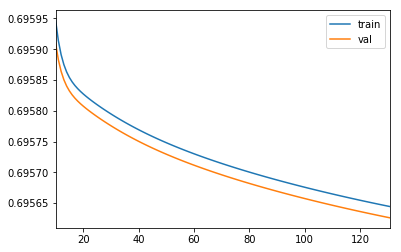

In [39]:
data_eval=pd.DataFrame({'train':running_loss_train_ls,'val':running_loss_test_ls})
data_eval[10:].plot()

In [57]:
1+1

2

In [20]:
model.eval()

ModelLstm(
  (lstm): LSTM(26, 25)
  (linear): Linear(in_features=25, out_features=15, bias=False)
  (sigmoid): Sigmoid()
)

In [21]:
## Training
XX=X_tr.copy()
XX=Variable(torch.from_numpy(XX).type('torch.DoubleTensor'))
yy=model(XX)

In [33]:
yy0=yy[0].data.numpy()
yy0=(yy0>0.5).astype(int).astype(str)
yy0=[''.join(i) for i in yy0]
yy0[:10]

['000000000000000',
 '000000000000000',
 '000000000000000',
 '000000000000000',
 '000000000000000',
 '000000000000000',
 '000000000000000',
 '000000000000000',
 '000000000000000',
 '000000000000000']

In [34]:
data_used_train['y_pred']=yy0

In [36]:
data_used_train.sample(10)

,source,target,ids,flag_space,y_pred
50144,melainkandaerah,melainkan daerah,1637189,000000001000000,000000000000000
67640,menegaskantiket,menegaskan tiket,1719973,000000000100000,000000000000000
87884,pelakusetiapini,pelaku setiap ini,1815936,000001000001000,000000000000000
32800,tahunberbobotdi,tahun berbobot di,1554907,000010000000100,000000000000000
60884,terpopulerdalam,terpopuler dalam,1687901,000000000100000,000000000000000
15182,identikinisudah,identik ini sudah,1471301,000000100100000,000000000000000
65497,denganpekerjaan,dengan pekerjaan,1709857,000001000000000,000000000000000
48114,mobiltahunsedan,mobil tahun sedan,1627587,000010000100000,000000000000000
58791,terkaitterhadap,terkait terhadap,1678152,000000100000000,000000000000000
31506,sertatariftahap,serta tarif tahap,1548878,000010000100000,000000000000000


## Test it

In [37]:
## Test it
XX=X_te.copy()
XX=Variable(torch.from_numpy(XX).type('torch.DoubleTensor'))
yy=model(XX)

In [38]:
yy0=yy[0].data.numpy()
yy0=(yy0>0.5).astype(int).astype(str)
yy0=[''.join(i) for i in yy0]
yy0[:10]

['000000000000000',
 '000000000000000',
 '000000000000000',
 '000000000000000',
 '000000000000000',
 '000000000000000',
 '000000000000000',
 '000000000000000',
 '000000000000000',
 '000000000000000']

In [39]:
data_used_test['y_pred']=yy0

/Users/alamhanz/anaconda/envs/word_s/lib/python3.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [40]:
data_used_train.sample(10)

,source,target,ids,flag_space,y_pred
12342,sepakperusahaan,sepak perusahaan,1457750,000010000000000,000000000000000
9138,miliarmelakukan,miliar melakukan,1442854,000001000000000,000000000000000
3403,asalpendaftaran,asal pendaftaran,1416167,000100000000000,000000000000000
74342,jelasnyastadium,jelasnya stadium,1751813,000000010000000,000000000000000
12597,cmnphargaplakat,cmnp harga plakat,1459043,000100001000000,000000000000000
86940,bahwadenganyang,bahwa dengan yang,1811573,000010000010000,000000000000000
54344,terjadibniingin,terjadi bni ingin,1657235,000000100100000,000000000000000
8989,untuktetappiper,untuk tetap piper,1442103,000010000100000,000000000000000
15108,ratelalusamping,rate lalu samping,1471008,000100010000000,000000000000000
28477,danyangnokiadwi,dan yang nokia dwi,1534286,001000100001000,000000000000000
